#DS/ML salary prediction - project description

* Objective: showcase proficiency in pyspark, mlflow and databricks through real data and ML project.
* ML project objective: predict salary.
* Datasets : Data scrubbed from [ai-jobs.net](https://ai-jobs.net/) into parquet file containing following columns:
1. `title` - job title
2. `location` - including city, country, region and others
3. `salary_etc` - information block containg salary info, seniority level, working hour , etc..
4. `company_name` - company name
5. `company_description` -short info on company
6. `blocks` -  html code of scrubbed web page.
7. `id` - ID
* Target: min salary offered
* Metrics : Mean Absolute Error
* Enviroment : project was initialy run on Databricks Community Edition platfrom. Due to platform compute limiation was eventaully moved to Google Colab. However it still can be run with no modifitcation on Databricks.
* Requirements: account on Databricks needed to run MLFlow server. Can be setup on free Community Edition version.


#Spark Init

In [253]:
%%capture
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    !apt-get update # Update apt-get repository.
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
    !wget - q https://dlcdn.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
    !tar xf spark-3.5.1-bin-hadoop3.tgz
    !pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

    import os
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

    import findspark
    findspark.init()

    from pyspark.sql import SparkSession
    spark = SparkSession.builder.master("local[*]").getOrCreate()
    spark






# MLFlow setup

In [254]:
%%capture
if IN_COLAB:
  !pip install mlflow
  !pip install databricks-cli

In [255]:

EXPERIMENT_NAME='/Users/jhofmanbb@gmail.com/DataJobs'

if IN_COLAB:
  !databricks configure --host https://community.cloud.databricks.com/
  import mlflow
  mlflow.set_tracking_uri("databricks")
  mlflow.set_experiment(EXPERIMENT_NAME)
else :
  import mlflow
  mlflow.set_experiment(EXPERIMENT_NAME)


Username: jhofmanbb@gmail.com
Password: 
Repeat for confirmation: 


#Library


In [256]:
%%capture
if IN_COLAB:
  !pip install unidecode
else:
 %sh pip install unidecode

In [257]:
from pyspark.sql.functions import col, split, expr,explode
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import udf,lower,lit,col, when, count, max,coalesce, size,length
from pyspark.sql.functions import concat_ws,struct,countDistinct, explode_outer
from pyspark.sql.functions import regexp_replace,regexp_extract,regexp_extract_all,array_distinct,array_contains
from pyspark.sql.types import IntegerType, ArrayType, StringType,FloatType,BooleanType
import re
from pyspark.sql import functions as F,Row
from pyspark.sql.window import Window


from pyspark.sql.functions import lit
from pyspark.sql.functions import col, count, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF
from pyspark.sql.functions import when,desc
from pyspark.ml.feature import OneHotEncoder,StringIndexer,Bucketizer
from pyspark.ml.regression import LinearRegression,DecisionTreeRegressor,GBTRegressor,RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from unidecode import unidecode
from pyspark.sql.types import StringType, StructField, StructType
from collections import Counter


# Dataset

In [258]:
if IN_COLAB:
    dj = spark.read.parquet("/content/drive/MyDrive/Colab Notebooks/DW/master_class/data_jobs/input/ds_jobs.parquet")
    cities_raw = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/DW/master_class/data_jobs/input/worldcities.csv",header=True)
else:
    dj = spark.read.parquet("dbfs:/FileStore/shared_uploads/jhofmanbb@gmail.com/ds_jobs-2.parquet")
    cities_raw = spark.read.csv('dbfs:/FileStore/shared_uploads/jhofmanbb@gmail.com/worldcities-1.csv',header=True)

In [259]:
cities_raw.printSchema()

root
 |-- city: string (nullable = true)
 |-- city_ascii: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lng: string (nullable = true)
 |-- country: string (nullable = true)
 |-- iso2: string (nullable = true)
 |-- iso3: string (nullable = true)
 |-- admin_name: string (nullable = true)
 |-- capital: string (nullable = true)
 |-- population: string (nullable = true)
 |-- id: string (nullable = true)



In [260]:
cities_raw.show(20)

+------------+------------+--------+--------+-------------+----+----+--------------------+-------+----------+----------+
|        city|  city_ascii|     lat|     lng|      country|iso2|iso3|          admin_name|capital|population|        id|
+------------+------------+--------+--------+-------------+----+----+--------------------+-------+----------+----------+
|       Tokyo|       Tokyo| 35.6897|139.6922|        Japan|  JP| JPN|               Tōkyō|primary|  37732000|1392685764|
|     Jakarta|     Jakarta| -6.1750|106.8275|    Indonesia|  ID| IDN|             Jakarta|primary|  33756000|1360771077|
|       Delhi|       Delhi| 28.6100| 77.2300|        India|  IN| IND|               Delhi|  admin|  32226000|1356872604|
|   Guangzhou|   Guangzhou| 23.1300|113.2600|        China|  CN| CHN|           Guangdong|  admin|  26940000|1156237133|
|      Mumbai|      Mumbai| 19.0761| 72.8775|        India|  IN| IND|         Mahārāshtra|  admin|  24973000|1356226629|
|      Manila|      Manila| 14.5

In [261]:
display(dj.printSchema())

root
 |-- title: string (nullable = true)
 |-- location: string (nullable = true)
 |-- salary_etc: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- company_name: string (nullable = true)
 |-- company_description: string (nullable = true)
 |-- blocks: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- class: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- href: string (nullable = true)
 |    |    |-- tag: string (nullable = true)
 |    |    |-- text: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- title: string (nullable = true)
 |-- id: string (nullable = true)



None

# Function

## extract_currency

In [262]:
def extract_currency(input_string):
  currency_list=['usd','eur','gbp','sgd']

  words = input_string.split()
  currency = [ word for word in words if word in currency_list]
  if currency: return currency[0]
  else: return None

extract_currency_udf=udf(extract_currency,StringType())


## select_words_ending_with_K

In [263]:
def select_words_ending_with_K(input_string):
    '''
    retrun list of words wich ends with 'K', 50k
    '''
    words = input_string.split()
    #selected_words = [int(re.sub(r'K', '000', word)) for word in words if word.endswith('K')]
    selected_words = [int(word[:-1] + '000') if word.endswith('K') else int(word[:-2] + '000')
    for word in words
    if word.endswith('K') or word.endswith('K+')]
    return selected_words

## words

In [264]:
def words():
  '''
  joined_string columns - salary_etc column transformed from array string to string
  shows all words in joined string column
  '''
  words=Tokenizer(inputCol='joined_string', outputCol='salary_all_word').transform(dj).select('salary_all_word')
  words.show(truncate=False)


## words_count

In [265]:
def words_count():
  '''
  shows all words and its count from joinee_string column
  '''
  words=Tokenizer(inputCol='joined_string', outputCol='salary_all_word').transform(dj).select('salary_all_word')
  words_c=words.withColumn('words',explode(col('salary_all_word'))).groupby('words').count().orderBy(col('count').desc())
  print('Number of unique words:',words_c.count())
  words_c.show(150,truncate=False)


## remove_from_joined_string

In [266]:
def remove_from_joined_string(dj, words_to_remove):
  '''
  remove words in words_to_remove list from joined_string column
  '''
  for word in words_to_remove:
    dj = dj.withColumn("joined_string", regexp_replace("joined_string", word, ""))
  return dj

## show_word


In [267]:


def word_search(input_string,word_seek):
    words = input_string.split()
    if word_seek in words: return True
    else:  return False
word_search_udf=udf(word_search,BooleanType())


def show_word(word_seek):
  '''
  shows the number of occurrences of word_seek in joined_string,
  and shows distinct rows from joined_string contained word_seek
  '''
  dj_temp=dj.withColumn('con',word_search_udf(dj['joined_string'],lit(word_seek)))
  print(f'Number of rows from joined_string with word {word_seek}: {dj_temp.filter("con").select("joined_string").count()}')
  print('Unique rows:')
  dj_temp.filter('con').select('joined_string').distinct().show(truncate=False)




## new_column_udf

In [268]:
def new_column(input_string, list_of_words,split_char=' '):
    '''
    column function, return first word from list_words found in input string
    or Null if nothing found
    '''
    words = input_string.split(split_char)
    selected_words = [word.strip() for word in words if word.strip() in list_of_words]
    if selected_words: return selected_words[0]
    else:  return None

new_column_udf=udf(new_column,StringType())

## replace_country

In [269]:
def replace_country(countries_list):
  '''
  Function replace countries from countries list with new value
  according to dictionary replac_countries_dict
  '''

  replace_countries_dict={
    'wales':'united kingdom',
    'uk':'united kingodm',
    'england':'united kingdom',
    'us':'united states',
    'usa':'united states',
    'méxico':'mexico'

}

  new_country_list=[]
  for country in countries_list:
    if country in replace_countries_dict:
      new_country_list.append(replace_countries_dict[country])
    else:
      new_country_list.append(country)

  return new_country_list



## replace_word_with_dict_udf

In [270]:
def replace_word_with_dict(list_of_strings,list_of_keys,list_of_values):
    '''
    Function replace strings from list_of_strings according to
    dictionary replace_word_dict created from list_of_keys and list_of_values
    '''


    replace_word_dict = dict(zip(list_of_keys, list_of_values))
    new_list_of_strings = []
    #print(replace_word_dict)
    for word in list_of_strings:
        #print(word)
        if word in replace_word_dict:
            new_list_of_strings.append(replace_word_dict[word])
        else:
            new_list_of_strings.append(word)

    return new_list_of_strings

replace_word_with_dict_udf=udf(replace_word_with_dict,ArrayType(StringType()))



## find_words_with_dict_udf

In [271]:
def find_words_with_dict(list_of_strings,list_of_keys,list_of_values):
    '''
    Function returns new_list_of_strings created from strings
    found on list_of_strings according to find_words_dict created from
    list_of_keys and list_of_values
    '''


    find_words_dict = dict(zip(list_of_keys, list_of_values))
    new_list_of_strings = []
    #print(replace_word_dict)
    for word in list_of_strings:
        #print(word)
        if word in find_words_dict:#list(find_words_dict.keys()):
            new_list_of_strings.append(find_words_dict[word])


    return new_list_of_strings
    return []

find_words_with_dict_udf=udf(find_words_with_dict,ArrayType(StringType()))


## make_country_column

In [272]:
def make_country_column(input_string,list_of_words,split_char=' '):
    '''
    column function, return list selected_words from list_words found in input string
    or Null if nothing found
    '''
    words = input_string.split(split_char)
    selected_words = [word.strip() for word in words if word.strip() in list_of_words]
    if selected_words:
      selected_words=replace_country(selected_words)
      return list(set(selected_words))
    else:  return None

make_country_column_udf=udf(make_country_column,ArrayType(StringType()))

## make_cities_column

In [273]:
def make_cities_column(input_string,list_of_words):
    '''
    column function, return list of words from list_words found in input string
    or Null if nothing found
    '''

    if input_string is None: return input_string
    else: return list(set(input_string)&set(list_of_words))

make_cities_column_udf=udf(make_cities_column,ArrayType(StringType()))

## make_column_udf

In [274]:
def make_column(input_string,list_of_words):
    '''
    column function, return list of words from list_words found in input string
    or Null if nothing found
    '''
    #words = input_string.split(split_char)

    #   selected_words = [word.strip() for word in input_string if word.strip() in list_of_words]
    # if selected_words:
    #   #selected_words=replace_country(selected_words)
    #   return list(set(selected_words))
    # else:  return None


    #words = input_string.split(split_char)
    if input_string is None: return input_string
    else: return list(set(input_string)&set(list_of_words))

    #   selected_words = [word.strip() for word in input_string if word.strip() in list_of_words]
    # if selected_words:
    #   #selected_words=replace_country(selected_words)
    #   return list(set(selected_words))
    # else:  return None
make_column_udf=udf(make_column,ArrayType(StringType()))

## convert_currency_to_usd

In [275]:
def convert_currency_to_usd(currency,salary):
  '''
  function converts salary to USD
  '''
  currency_convertion_dict={
    'usd':1,
    'gbp':1.26,
    'eur':1.08,
    'sgd':0.743
  }

  if currency is not None and salary is not None:
    return salary*currency_convertion_dict.get(currency.lower(), 1)
  else:
    return None

convert_currency_to_usd_udf=udf(convert_currency_to_usd,FloatType())

## run_model_cv

In [276]:
def run_model_cv(model,train,features_cols,params=None, pred_col='prediction',label_col='label',comments='',seed=23):
  '''
  function runs model and logs info into MLflow experiment
  '''

  with mlflow.start_run(run_name=model.__class__.__name__) as run:
    mlflow.log_param("features_cols", features_cols)

    params = ParamGridBuilder().build()
    pipeline=create_pipeline(features_cols,model)
    evaluator = RegressionEvaluator(labelCol=label_col,metricName='mae')
    crossValidator = CrossValidator(estimator=pipeline,
                                    estimatorParamMaps=params,
                                    evaluator=evaluator,
                                    numFolds=3,
                                    seed=seed)
    cvmodel=crossValidator.fit(train)

    mlflow.log_metric("mae_test", cvmodel.avgMetrics[0])
    mlflow.set_tag('comments',comments)




## show_nulls

In [277]:
def show_nulls(df,cols,df_name=''):
   print(f'Number of nulls in: {df_name}')
   for colu in cols:
    print(f'{colu}: {df.filter(col(colu).isNull()).count()}')

## create_featured_df

In [278]:
def create_featured_df(df,features_cols,label_col):
    '''
    return new df with feature columns and label column only
    '''

    cols_to_select=features_cols.copy()
    cols_to_select.append(label_col)
    result_df=df.select(cols_to_select).withColumn('label',col(label_col))
    return result_df

## create_pipeline

In [279]:
def create_pipeline(trans_cols,model=None,label_col='label'):

    '''
    function dynamicaly create piepline for columns in trans cols
    return pipeline object
    '''
    stages = []
    #print('Przekazane trans_cols',trans_cols)

    for col_name in trans_cols:

        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_idx", handleInvalid='keep')
        stages.append(indexer)


        onehot = OneHotEncoder(inputCols=[f"{col_name}_idx"], outputCols=[f"{col_name}_dummy"])
        stages.append(onehot)


    input_cols = [f"{col_name}_dummy" for col_name in trans_cols]

    #print('Input cols po onehote',input_cols)

    assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
    stages.append(assembler)

    if model :
      stages.append(model)


    return Pipeline(stages=stages)


## replace_diatrics_with_letters_udf

In [280]:
def replace_diacritics_with_letters(input_string):
    '''
    replaces diacctrics with letters
    '''
    text =input_string.lower()
    return unidecode(text)

replace_diacritics_with_letters_udf=udf(replace_diacritics_with_letters,StringType())

## make_list_of_string

In [281]:
def make_list_of_string(list_of_strings,split_char=','):

    if list_of_strings is not None:
        return [word.strip(split_char).strip() for word in list_of_strings.split(split_char) if word.strip()]
    else : return list_of_strings

make_list_of_string_udf = udf(make_list_of_string,ArrayType(StringType()))

## make_length_column_udf

In [282]:
'''
returns length of string
'''
make_length_column_udf=udf(lambda input_string:len(input_string) if input_string is not None else 0,IntegerType())

## get_words_from_column

In [283]:
def get_words_from_column(df,column):
    '''
    Function return list of words from all words in column. Column must be Arrary of strings

    '''
    df_exploded = df.select(explode(df[column]).alias("word"))
    words_list = [row["word"] for row in df_exploded.collect()]

    return words_list

## get_number_words_on_list

In [284]:
def get_number_words_on_list(word_list):
    '''
    Function retrun list of tuple (words, number of word on word_list)
    '''
    return Counter(word_list).most_common()

## make_distinct_column_udf

In [285]:
def make_distinct_column(list_of_string):
    '''
    Function make values in row dsitinct
    '''
    return list(set(list_of_string))
make_distinct_column_udf=udf(make_distinct_column,ArrayType(StringType()))

## make_remote_column_udf

In [286]:
def make_remote_column(list_of_string):
    '''
    Function return True if remote or hybrid word in list of string
    '''
    if len(set(list_of_string)&{'remote','hybrid'})>0 :
        return True
    else: return False

make_remote_column_udf=udf(make_remote_column,BooleanType())

## remove_remote_from_country_udf

In [287]:
def remove_remote_from_country(list_of_string):
    '''
    Function removes from list of string words : remote , hybrid
    '''

    return  list(set(list_of_string).difference({'remote','hybrid'}))
remove_remote_from_country_udf=udf(remove_remote_from_country,ArrayType(StringType()))

## find_matching_title_udf

In [288]:
def find_matching_title(strings_list, title_list):
    for title in title_list:
        if title in strings_list:
            return title
    return None

find_matching_title_udf=udf(find_matching_title,StringType())

# DATA CLEANING / TRANSFORMATION

# salary_etc

In [289]:
dj.select('salary_etc').show(truncate=False)

+---------------------------------------------------------+
|salary_etc                                               |
+---------------------------------------------------------+
|[Full Time, Senior-level / Expert, USD 115K - 180K *]    |
|[Full Time, Senior-level / Expert, USD 48K - 90K *]      |
|[Full Time, Senior-level / Expert, USD 69K - 128K *]     |
|[Full Time, Senior-level / Expert, USD 62K - 115K *]     |
|[Full Time, Senior-level / Expert, USD 70K - 135K]       |
|[Full Time, Senior-level / Expert, USD 69K - 128K *]     |
|[Full Time, Entry-level / Junior, USD 44K - 81K *]       |
|[Full Time, Senior-level / Expert, USD 62K - 115K *]     |
|[Full Time, Senior-level / Expert, USD 120K - 202K *]    |
|[Full Time, Entry-level / Junior, USD 44K - 81K *]       |
|[Full Time, Senior-level / Expert, USD 55K - 102K *]     |
|[Full Time, Mid-level / Intermediate, USD 70K - 110K *]  |
|[Full Time, Mid-level / Intermediate, USD 90K - 147K *]  |
|[Full Time, Senior-level / Expert, USD 

## salary_min, salary_max

In [290]:
#  joined_string column created as concatation of all words in salary_etc
#
dj = dj.withColumn("joined_string", concat_ws(" ", col("salary_etc")))
dj= dj.withColumn('joined_string', regexp_replace('joined_string', '[_()*/:;,.!?\\-]', ' '))


In [291]:
# salary_all column created form joined_string. sallary all contains list like ['50k','100k'] or Null
select_words_ending_with_K_udf = udf(select_words_ending_with_K, ArrayType(StringType()))
dj=dj.withColumn("salary_all", select_words_ending_with_K_udf (dj["joined_string"]))


In [292]:
# salary_min, salary_max creation
dj = dj.withColumn("salary_min", col("salary_all").getItem(0).cast(FloatType())) \
       .withColumn("salary_max", col("salary_all").getItem(1).cast(FloatType()))

In [293]:
dj.select('salary_min','salary_max').show()

+----------+----------+
|salary_min|salary_max|
+----------+----------+
|  115000.0|  180000.0|
|   48000.0|   90000.0|
|   69000.0|  128000.0|
|   62000.0|  115000.0|
|   70000.0|  135000.0|
|   69000.0|  128000.0|
|   44000.0|   81000.0|
|   62000.0|  115000.0|
|  120000.0|  202000.0|
|   44000.0|   81000.0|
|   55000.0|  102000.0|
|   70000.0|  110000.0|
|   90000.0|  147000.0|
|  129000.0|  185000.0|
|   50000.0|  130000.0|
|   80000.0|  138000.0|
|  131000.0|  240000.0|
|   69000.0|  128000.0|
|   66000.0|  123000.0|
|   62000.0|  115000.0|
+----------+----------+
only showing top 20 rows



In [294]:
show_word('SGD')

Number of rows from joined_string with word SGD: 1
Unique rows:
+-----------------------------------------+
|joined_string                            |
+-----------------------------------------+
|Full Time Senior level   Expert SGD 120K+|
+-----------------------------------------+



In [295]:
dj.select('salary_min','salary_max').describe().show()

+-------+------------------+------------------+
|summary|        salary_min|        salary_max|
+-------+------------------+------------------+
|  count|              3130|              3053|
|   mean| 92436.42172523962| 149687.8480183426|
| stddev|42499.502179414034|55343.368528598075|
|    min|           30000.0|           44000.0|
|    max|          359000.0|          405000.0|
+-------+------------------+------------------+



In [296]:
# numbers of Null in salary min
print(f'numbers of nulls in salary min: {dj.filter(col("salary_min").isNull()).count()}')

numbers of nulls in salary min: 122


In [297]:
# numbers of null in salary_max
print(f'Numbers of nulls in salary_max: {dj.filter(col("salary_max").isNull()).count()}')

Numbers of nulls in salary_max: 199


In [298]:

print('rows not null at salary min and null with salaary_max')
dj.filter(dj["salary_min"].isNotNull() & dj["salary_max"].isNull()).select('salary_min','salary_max').show()

rows not null at salary min and null with salaary_max
+----------+----------+
|salary_min|salary_max|
+----------+----------+
|   70000.0|      NULL|
|  210000.0|      NULL|
|   60000.0|      NULL|
|  180000.0|      NULL|
|  110000.0|      NULL|
|   36000.0|      NULL|
|  140000.0|      NULL|
|  150000.0|      NULL|
|   45000.0|      NULL|
|  180000.0|      NULL|
|  245000.0|      NULL|
|   45000.0|      NULL|
|  330000.0|      NULL|
|   70000.0|      NULL|
|  130000.0|      NULL|
|   70000.0|      NULL|
|  129000.0|      NULL|
|   60000.0|      NULL|
|   50000.0|      NULL|
|  195000.0|      NULL|
+----------+----------+
only showing top 20 rows



In [299]:
print('is any salary_min greater than salary_max')

dj.filter(dj["salary_min"]>dj["salary_max"]).select('salary_min','salary_max').show()

is any salary_min greater than salary_max
+----------+----------+
|salary_min|salary_max|
+----------+----------+
+----------+----------+



In [300]:
print(' is any salary_min equal salary_max')
dj.filter(dj["salary_min"]==dj["salary_max"]).select('salary_min','salary_max').count()

 is any salary_min equal salary_max


0

In [301]:
dj=dj.drop('salary_all')

In [302]:
# remove numbers from joined_string
dj= dj.withColumn("joined_string", regexp_replace(col("joined_string"), r"(\d+)K", '') )

In [303]:
#lower joined string
dj = dj.withColumn("joined_string", lower(dj["joined_string"]))
dj.select('joined_string').show(20,truncate=False)

+----------------------------------------------+
|joined_string                                 |
+----------------------------------------------+
|full time senior level   expert usd           |
|full time senior level   expert usd           |
|full time senior level   expert usd           |
|full time senior level   expert usd           |
|full time senior level   expert usd           |
|full time senior level   expert usd           |
|full time entry level   junior usd            |
|full time senior level   expert usd           |
|full time senior level   expert usd           |
|full time entry level   junior usd            |
|full time senior level   expert usd           |
|full time mid level   intermediate usd        |
|full time mid level   intermediate usd        |
|full time senior level   expert usd           |
|full time entry level   junior usd            |
|full time usd                                 |
|full time senior level   expert usd           |
|full time senior le

## currency

In [304]:
words()

+-------------------------------------------------+
|salary_all_word                                  |
+-------------------------------------------------+
|[full, time, senior, level, , , expert, usd]     |
|[full, time, senior, level, , , expert, usd]     |
|[full, time, senior, level, , , expert, usd]     |
|[full, time, senior, level, , , expert, usd]     |
|[full, time, senior, level, , , expert, usd]     |
|[full, time, senior, level, , , expert, usd]     |
|[full, time, entry, level, , , junior, usd]      |
|[full, time, senior, level, , , expert, usd]     |
|[full, time, senior, level, , , expert, usd]     |
|[full, time, entry, level, , , junior, usd]      |
|[full, time, senior, level, , , expert, usd]     |
|[full, time, mid, level, , , intermediate, usd]  |
|[full, time, mid, level, , , intermediate, usd]  |
|[full, time, senior, level, , , expert, usd]     |
|[full, time, entry, level, , , junior, usd]      |
|[full, time, usd]                                |
|[full, time

In [305]:
#all three letters words from joined_string to check currency
words_df=Tokenizer(inputCol='joined_string', outputCol='salary_all_word').transform(dj).select('salary_all_word')
words_c=words_df.withColumn('words',explode(col('salary_all_word'))).groupby('words').count().orderBy(col('count').desc())
unique_words_list = [row.words for row in words_c.select('words').distinct().collect()]
three_letter_words=[word for word in unique_words_list if len(word) == 3]

print(three_letter_words)

['usd', 'mid', 'and', 'the', 'for', 'gbp', 'eur', 'any', 'you', 'age', 'are', 'sex', 'law', 'eeo', 'san', 'com', 'new', 'job', 'due', 'let', 'all', 'not', 'one', 'sgd', 'our', 'key']


In [306]:
currency_list =['usd','gbp','eur','sgd']

In [307]:
#column currency created from joined_string
dj=dj.withColumn('currency',extract_currency_udf('joined_string'))

In [308]:
dj.filter(col("currency")=='sgd').select('salary_min','salary_max').show(truncate=False)

+----------+----------+
|salary_min|salary_max|
+----------+----------+
|120000.0  |NULL      |
+----------+----------+



In [309]:
#number of nulls in currency
print(f'number of nulls in currency : {dj.filter(col("currency").isNull()).count()}')

number of nulls in currency : 122


In [310]:
dj.printSchema()

root
 |-- title: string (nullable = true)
 |-- location: string (nullable = true)
 |-- salary_etc: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- company_name: string (nullable = true)
 |-- company_description: string (nullable = true)
 |-- blocks: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- class: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- href: string (nullable = true)
 |    |    |-- tag: string (nullable = true)
 |    |    |-- text: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- title: string (nullable = true)
 |-- id: string (nullable = true)
 |-- joined_string: string (nullable = false)
 |-- salary_min: float (nullable = true)
 |-- salary_max: float (nullable = true)
 |-- currency: string (nullable = true)



In [311]:
#get currency info from company name column

In [312]:
companies_with_null_currency=dj.filter(col('currency').isNull()).select('company_name').distinct()

In [313]:
print(f'Number of companies: {dj.select("company_name").distinct().count()}')

Number of companies: 1047


In [314]:
print(f'Number of companies with null at currency: {companies_with_null_currency.count()}')

Number of companies with null at currency: 66


In [315]:
companies_with_null_currency=dj.filter(col('currency').isNull()).select('company_name').distinct()
grouped=dj.groupBy('company_name','currency').count()
filtered_grouped = grouped.join(companies_with_null_currency, 'company_name')


In [316]:
print('Companies with null and not null currencies')
filtered_grouped.orderBy(col("company_name")).show()

Companies with null and not null currencies
+------------------+--------+-----+
|      company_name|currency|count|
+------------------+--------+-----+
|          ASSYSTEM|    NULL|    4|
|          ASSYSTEM|     usd|    1|
|             Agoda|    NULL|    1|
|             Agoda|     usd|   19|
|        Amazon.com|    NULL|    1|
|        Amazon.com|     usd|   41|
|Anduril Industries|     usd|    5|
|Anduril Industries|    NULL|    1|
|            Aqemia|    NULL|    3|
|       Bosch Group|    NULL|   22|
|       Bosch Group|     usd|   96|
|         CS Energy|    NULL|    1|
|CapTech Consulting|    NULL|    1|
|CapTech Consulting|     usd|    5|
|   Carousell Group|    NULL|    1|
|            Cohere|     usd|    4|
|            Cohere|    NULL|    1|
|    DataCamp, Inc.|    NULL|    1|
|          Devoteam|     usd|   29|
|          Devoteam|    NULL|    1|
+------------------+--------+-----+
only showing top 20 rows



In [317]:
companies_with_null_only=filtered_grouped.groupBy('company_name').count().filter(col("count")==1).select('company_name').distinct()

In [318]:
print(f'Number of companies with no currency defined (null only): {companies_with_null_only.count()}')

Number of companies with no currency defined (null only): 24


In [319]:
#only companies with null and not null currency
companies_with_not_null_only=filtered_grouped.groupBy('company_name').count().filter(col("count")>1).select('company_name')

In [320]:
#only companies with null and not null currency with currency column
filtered_with_not_null_only=filtered_grouped.join(companies_with_not_null_only,'company_name')

In [321]:
filtered_with_not_null_only.orderBy(col("company_name")).show()

+------------------+--------+-----+
|      company_name|currency|count|
+------------------+--------+-----+
|          ASSYSTEM|    NULL|    4|
|          ASSYSTEM|     usd|    1|
|             Agoda|    NULL|    1|
|             Agoda|     usd|   19|
|        Amazon.com|    NULL|    1|
|        Amazon.com|     usd|   41|
|Anduril Industries|    NULL|    1|
|Anduril Industries|     usd|    5|
|       Bosch Group|    NULL|   22|
|       Bosch Group|     usd|   96|
|CapTech Consulting|    NULL|    1|
|CapTech Consulting|     usd|    5|
|            Cohere|    NULL|    1|
|            Cohere|     usd|    4|
|          Devoteam|     usd|   29|
|          Devoteam|    NULL|    1|
|        Docplanner|    NULL|    1|
|        Docplanner|     usd|    4|
|          EcoVadis|    NULL|    1|
|          EcoVadis|     usd|    5|
+------------------+--------+-----+
only showing top 20 rows



In [322]:
filtered_with_not_null_only=filtered_with_not_null_only.filter(col("currency").isNotNull()).drop('count')

In [323]:
filtered_with_not_null_only.orderBy(col("company_name")).show()

+--------------------+--------+
|        company_name|currency|
+--------------------+--------+
|            ASSYSTEM|     usd|
|               Agoda|     usd|
|          Amazon.com|     usd|
|  Anduril Industries|     usd|
|         Bosch Group|     usd|
|  CapTech Consulting|     usd|
|              Cohere|     usd|
|            Devoteam|     usd|
|          Docplanner|     usd|
|            EcoVadis|     usd|
|    Extreme Networks|     usd|
|               Fetch|     usd|
|               Figma|     usd|
|Flagship Pioneeri...|     usd|
|          Homa Games|     usd|
|                Hudl|     usd|
|             Kinaxis|     usd|
|        Lucid Motors|     usd|
|            Miratech|     usd|
|           NielsenIQ|     usd|
+--------------------+--------+
only showing top 20 rows



In [324]:
print(f'Number of companies where currency null can be updated: {filtered_with_not_null_only.count()}')

Number of companies where currency null can be updated: 42


In [325]:
# join to select rows with companies with null and not null currency
dj_joined= dj.join(filtered_with_not_null_only.withColumnRenamed("currency", "currency_non_null"),
                     on="company_name",
                     how="left")
#replace null in currency by value from currency non null
dj = dj_joined.withColumn("currency", coalesce("currency", "currency_non_null")) \
                                    .drop("currency_non_null")

In [326]:
print(f'Number of nulls in currency after transformation :{dj.filter(col("currency").isNull()).count()}')

Number of nulls in currency after transformation :30


In [327]:

# salaries convertion to usd
dj=dj.withColumn('salary_min_usd',convert_currency_to_usd_udf('currency','salary_min'))
dj=dj.withColumn('salary_max_usd',convert_currency_to_usd_udf('currency','salary_max'))


In [328]:
print('Salaries for sgd currency')
dj.filter(col("currency")=='sgd').select('salary_min','salary_min_usd','salary_max_usd','salary_max_usd').show(truncate=False)

Salaries for sgd currency
+----------+--------------+--------------+--------------+
|salary_min|salary_min_usd|salary_max_usd|salary_max_usd|
+----------+--------------+--------------+--------------+
|120000.0  |89160.0       |NULL          |NULL          |
+----------+--------------+--------------+--------------+



In [329]:
#remove currency from joined_string

dj=remove_from_joined_string(dj,currency_list)


In [330]:
words()

+--------------------------------------------+
|salary_all_word                             |
+--------------------------------------------+
|[full, time, senior, level, , , expert]     |
|[full, time, senior, level, , , expert]     |
|[full, time, senior, level, , , expert]     |
|[full, time, senior, level, , , expert]     |
|[full, time, senior, level, , , expert]     |
|[full, time, senior, level, , , expert]     |
|[full, time, entry, level, , , junior]      |
|[full, time, senior, level, , , expert]     |
|[full, time, senior, level, , , expert]     |
|[full, time, entry, level, , , junior]      |
|[full, time, senior, level, , , expert]     |
|[full, time, mid, level, , , intermediate]  |
|[full, time, mid, level, , , intermediate]  |
|[full, time, senior, level, , , expert]     |
|[full, time, entry, level, , , junior]      |
|[full, time]                                |
|[full, time, senior, level, , , expert]     |
|[full, time, senior, level, , , expert]     |
|[full, time,

## seniority level

In [331]:
# remove time and level from joined_string
dj=remove_from_joined_string(dj,['level','time'])

In [332]:
words()

+-----------------------------------+
|salary_all_word                    |
+-----------------------------------+
|[full, , senior, , , , expert]     |
|[full, , senior, , , , expert]     |
|[full, , senior, , , , expert]     |
|[full, , senior, , , , expert]     |
|[full, , senior, , , , expert]     |
|[full, , senior, , , , expert]     |
|[full, , entry, , , , junior]      |
|[full, , senior, , , , expert]     |
|[full, , senior, , , , expert]     |
|[full, , entry, , , , junior]      |
|[full, , senior, , , , expert]     |
|[full, , mid, , , , intermediate]  |
|[full, , mid, , , , intermediate]  |
|[full, , senior, , , , expert]     |
|[full, , entry, , , , junior]      |
|[full]                             |
|[full, , senior, , , , expert]     |
|[full, , senior, , , , expert]     |
|[full, , executive, , , , director]|
|[full, , senior, , , , expert]     |
+-----------------------------------+
only showing top 20 rows



In [333]:
# list of words describing seniorty level
seniority_level_list=['senior','mid','entry','executive','internship']

In [334]:
# create new colum seniortity level,
dj=dj.withColumn('seniority_level',new_column_udf(dj['joined_string'],lit(seniority_level_list)))

In [335]:
dj.select('seniority_level').distinct().show()

+---------------+
|seniority_level|
+---------------+
|            mid|
|          entry|
|      executive|
|         senior|
|     internship|
|           NULL|
+---------------+



In [336]:

print(f'NUmber of nulls in seniority_level: {dj.filter(col("seniority_level").isNull()).count()}')

NUmber of nulls in seniority_level: 296


In [337]:
print('joined_string distinct rows with Null at seniority_level')
dj.filter(col("seniority_level").isNull()).select('joined_string').distinct().show(truncate=False)

joined_string distinct rows with Null at seniority_level
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|joined_string                                                                                                                                                                     |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|full  clearance required                                                                                                                                                          |
|full   +                                                                                                                                                                          |
|full         note  we rely on legitim

In [338]:
#remove words from seniority_level_list from joined_string
dj=remove_from_joined_string(dj,seniority_level_list)

In [339]:
dj.filter(col('seniority_level').isNull()).count()

296

## update seniority level with title info

In [340]:

dj = dj.withColumn('title',lower(col('title')))
dj = dj.withColumn('title_array', regexp_replace('title', '[_()*&/:;|,.!?\\-]', ' '))
dj = dj.withColumn('title_array', replace_diacritics_with_letters_udf(col('title_array')))


dj=dj.withColumn('title_array',make_list_of_string_udf(col('title_array'),lit(' ')))

In [341]:
print('Number of distinct rows in title_array')
dj.select('title_array').distinct().count()#show(50,truncate=False)

Number of distinct rows in title_array


2191

In [342]:

dj.select('title_array').distinct().sample(False,0.1).show(20,truncate=False)

+-----------------------------------------------------------------------------------+
|title_array                                                                        |
+-----------------------------------------------------------------------------------+
|[it, support, ai, company]                                                         |
|[[paris], data, engineer, h, f]                                                    |
|[senior, software, engineer, machine, learning]                                    |
|[data, developer]                                                                  |
|[sr, principal, ui, engineer, data, visualization]                                 |
|[planning, ir, data, strategy, architect, business, intelligence]                  |
|[applied, scientist, ml, chercheur, euse, applique, e, ml]                         |
|[staff, business, intelligence, engineer]                                          |
|[educational, prompt, engineer]                      

In [343]:
print('Distinct words from the title_array along with the number of occurrences ')
get_number_words_on_list(get_words_from_column(dj,'title_array'))

Distinct words from the title_array along with the number of occurrences 


[('data', 2267),
 ('engineer', 1234),
 ('senior', 826),
 ('analyst', 582),
 ('scientist', 537),
 ('learning', 371),
 ('machine', 356),
 ('manager', 241),
 ('ai', 202),
 ('analytics', 200),
 ('f', 168),
 ('software', 165),
 ('science', 161),
 ('lead', 151),
 ('business', 147),
 ('staff', 142),
 ('intelligence', 138),
 ('engineering', 134),
 ('research', 130),
 ('remote', 126),
 ('sr', 115),
 ('h', 99),
 ('ml', 98),
 ('product', 94),
 ('consultant', 90),
 ('m', 89),
 ('and', 89),
 ('developer', 85),
 ('big', 84),
 ('intern', 83),
 ('architect', 80),
 ('bi', 76),
 ('principal', 70),
 ('associate', 69),
 ('director', 63),
 ('specialist', 63),
 ('management', 61),
 ('platform', 55),
 ('operations', 54),
 ('applied', 54),
 ('robotics', 49),
 ('cloud', 48),
 ('quality', 47),
 ('of', 47),
 ('2024', 45),
 ('team', 44),
 ('for', 44),
 ('d', 42),
 ('in', 42),
 ('-', 41),
 ('power', 41),
 ('junior', 39),
 ('marketing', 36),
 ('solutions', 36),
 ('vision', 35),
 ('internship', 34),
 ('generative', 

In [344]:
print('title array information for seniority_level nulls')
dj.filter(col('seniority_level').isNull()).select('title_array').show(300,truncate=False)


title array information for seniority_level nulls
+-------------------------------------------------------------------------------------------+
|title_array                                                                                |
+-------------------------------------------------------------------------------------------+
|[opening, data, analyst, work, from, home]                                                 |
|[deployment, robotics, engineer, europe]                                                   |
|[co, found, with, founders, factory, fintech, studio, ai, in, investment, banking]         |
|[qa, and, data, analyst, microsoft, dynamics]                                              |
|[data, scientist]                                                                          |
|[machine, learning, scientist]                                                             |
|[data, engagement, consultant]                                                             |
|[lead, da

In [345]:

dj.select('title_array','seniority_level').distinct().sample(False,0.1).show(20,truncate=False)

+-----------------------------------------------------------------+---------------+
|title_array                                                      |seniority_level|
+-----------------------------------------------------------------+---------------+
|[senior, software, engineer, net, +, python, data, science, ai]  |senior         |
|[director, of, business, intelligence, analytics]                |executive      |
|[cloud, data, engineer]                                          |senior         |
|[educational, prompt, engineer]                                  |mid            |
|[people, data, lead]                                             |senior         |
|[senior, strategic, alliances, manager, cloud, data, platforms]  |senior         |
|[software, engineer, 3, linux, python, kubernetes, pytorch, helm]|senior         |
|[machine, learning, engineer, embedded, project]                 |mid            |
|[applied, scientist, ml, chercheur, euse, applique, e, ml]       |NULL     

In [346]:
update_level_with_title_dict={
    'senior':'senior',
    'sr':'senior',
    'manager':'senior',
    'lead':'senior',
    'expert':'senior',
    'master':'senior',
    'head':'senior',
    'mid':'mid',
    'specialist':'mid',
    'middle':'mid',
    'director':'executive',
    'president':'executive',
    'vp':'executive',
    'vice':'executive',
    'junior':'entry',
    'juniora':'entry',
    'graduate':'entry',
    'graduating':'entry',
    'intern':'internship'
  }

In [347]:
# create seniority_level_from_title column finding words from update_level_with_title_dict in title_array
dj=dj.withColumn('seniority_level_from_title',find_words_with_dict_udf(col('title_array'),lit(list(update_level_with_title_dict.keys())),
                                                                         lit(list(update_level_with_title_dict.values()))))

In [348]:
# remove repetition from seniority level _from title
dj=dj.withColumn('seniority_level_from_title',make_distinct_column_udf('seniority_level_from_title'))

In [349]:
# keep only single values, otherwise null
dj = dj.withColumn('seniority_level_from_title',
                   when((size('seniority_level_from_title') == 0)|(size('seniority_level_from_title') >1), None).otherwise(dj['seniority_level_from_title']))

In [350]:
#removes void chars.
dj = dj.withColumn('seniority_level_from_title',
                   when(length(concat_ws('', dj['seniority_level_from_title'])) == 0, None)
                   .otherwise(concat_ws('', dj['seniority_level_from_title'])))

In [351]:
dj.select('seniority_level_from_title').distinct().show()

+--------------------------+
|seniority_level_from_title|
+--------------------------+
|                       mid|
|                 executive|
|                     entry|
|                    senior|
|                internship|
|                      NULL|
+--------------------------+



In [352]:
print('Number of nulls in seniority_level before update')
dj.filter(col('seniority_level').isNull()).count()

Number of nulls in seniority_level before update


296

In [353]:
dj= dj.withColumn('seniority_level', coalesce(dj['seniority_level'], dj['seniority_level_from_title']))

In [354]:
print('Number of nulls in seniority_level after update')
dj.filter(col('seniority_level').isNull()).count()

Number of nulls in seniority_level after update


239

## working_hours

In [355]:
words()

+------------------------------+
|salary_all_word               |
+------------------------------+
|[full, , , , , , expert]      |
|[full, , , , , , expert]      |
|[full, , , , , , expert]      |
|[full, , , , , , expert]      |
|[full, , , , , , expert]      |
|[full, , , , , , expert]      |
|[full, , , , , , junior]      |
|[full, , , , , , expert]      |
|[full, , , , , , expert]      |
|[full, , , , , , junior]      |
|[full, , , , , , expert]      |
|[full, , , , , , intermediate]|
|[full, , , , , , intermediate]|
|[full, , , , , , expert]      |
|[full, , , , , , junior]      |
|[full]                        |
|[full, , , , , , expert]      |
|[full, , , , , , expert]      |
|[full, , , , , , director]    |
|[full, , , , , , expert]      |
+------------------------------+
only showing top 20 rows



In [356]:
working_hour_list=['full','part']

In [357]:
# creating column working_hour
dj=dj.withColumn('working_hour',new_column_udf(dj['joined_string'],lit(working_hour_list)))

In [358]:

dj.groupBy('working_hour').count().show()

+------------+-----+
|working_hour|count|
+------------+-----+
|        NULL|   98|
|        full| 3148|
|        part|    6|
+------------+-----+



In [359]:
dj=remove_from_joined_string(dj,working_hour_list)

## position

In [360]:
position_list=['expert','junior','intermediate','director']

In [361]:

dj=dj.withColumn('position',new_column_udf(dj['joined_string'],lit(position_list)))


In [362]:
dj.groupBy('position').count().show()

+------------+-----+
|    position|count|
+------------+-----+
|      expert| 1805|
|        NULL|  296|
|intermediate|  489|
|    director|  122|
|      junior|  540|
+------------+-----+



In [363]:
print('Seniority level value for expert')
dj.filter(col('position')=='expert').select('seniority_level','position').distinct().show(truncate=False)

Seniority level value for expert
+---------------+--------+
|seniority_level|position|
+---------------+--------+
|senior         |expert  |
+---------------+--------+



In [364]:
print('is there any senior in seniorirty_level  with no expert in position?')
dj.filter((col('seniority_level') == 'senior') & (col('position') != 'expert')).select('seniority_level','position').show()
print('is there any expert in position with no senior in seniorirty level ?')

dj.filter((col('seniority_level') != 'senior') & (col('position') == 'expert')).select('position','seniority_level').show()

is there any senior in seniorirty_level  with no expert in position?
+---------------+--------+
|seniority_level|position|
+---------------+--------+
+---------------+--------+

is there any expert in position with no senior in seniorirty level ?
+--------+---------------+
|position|seniority_level|
+--------+---------------+
+--------+---------------+



In [365]:
print('Seniority level value for junior')
dj.filter(col('position')=='junior').select('seniority_level','position').distinct().show(truncate=False)

Seniority level value for junior
+---------------+--------+
|seniority_level|position|
+---------------+--------+
|internship     |junior  |
|entry          |junior  |
+---------------+--------+



In [366]:
print("Is there entry or internship with no junior?")
dj.filter(((col('seniority_level') == 'entry') | (col('seniority_level') == 'internship')) & (col('position') != 'junior')).select('seniority_level','position').show()
print("is ther any junior with no entry or internship?")
dj.filter(((col('seniority_level') != 'entry') & (col('seniority_level') != 'internship')) & (col('position') == 'junior')).select('position','seniority_level',).show()

Is there entry or internship with no junior?
+---------------+--------+
|seniority_level|position|
+---------------+--------+
+---------------+--------+

is ther any junior with no entry or internship?
+--------+---------------+
|position|seniority_level|
+--------+---------------+
+--------+---------------+



In [367]:
print(f' Number of distinct rows for junior and seniority_level values : \
  {dj.filter(col("position")=="junior").select("seniority_level","position").distinct().count()}')

 Number of distinct rows for junior and seniority_level values :   2


In [368]:
print( f'Number of rows with junior: {dj.filter(col("position")=="junior").count()}')

Number of rows with junior: 540


In [369]:
print('Seniority_level value for intermediate')
dj.filter(col('position')=='intermediate').select('seniority_level','position').distinct().show(truncate=False)

Seniority_level value for intermediate
+---------------+------------+
|seniority_level|position    |
+---------------+------------+
|mid            |intermediate|
+---------------+------------+



In [370]:
print('is there any mid in seniorirty_level  with no intermediate in position?')
dj.filter((col('seniority_level') == 'mid') & (col('position') != 'intermediate')).select('seniority_level','position').show()

print('is there any inermediate in position with no mid in seniorirty level ?')
dj.filter((col('seniority_level') != 'mid') & (col('position') == 'intermediate')).select('position','seniority_level').show()

is there any mid in seniorirty_level  with no intermediate in position?
+---------------+--------+
|seniority_level|position|
+---------------+--------+
+---------------+--------+

is there any inermediate in position with no mid in seniorirty level ?
+--------+---------------+
|position|seniority_level|
+--------+---------------+
+--------+---------------+



In [371]:
print('Seniority_level value for director')
dj.filter(col('position')=='director').select('seniority_level','position').distinct().show(truncate=False)

Seniority_level value for director
+---------------+--------+
|seniority_level|position|
+---------------+--------+
|executive      |director|
+---------------+--------+



In [372]:
print('is there any executive in seniorirty_level  with no director in position?')
dj.filter((col('seniority_level') == 'executive') & (col('position') != 'director')).select('seniority_level','position').show()

print('is there any inermediate in position with no mid in seniorirty level ?')
dj.filter((col('seniority_level') != 'executive') & (col('position') == 'director')).select('position','seniority_level').show()

is there any executive in seniorirty_level  with no director in position?
+---------------+--------+
|seniority_level|position|
+---------------+--------+
+---------------+--------+

is there any inermediate in position with no mid in seniorirty level ?
+--------+---------------+
|position|seniority_level|
+--------+---------------+
+--------+---------------+



In [373]:
words_count()

Number of unique words: 194
+-------------------+-----+
|words              |count|
+-------------------+-----+
|                   |18261|
|expert             |1805 |
|junior             |540  |
|intermediate       |489  |
|director           |122  |
|required           |99   |
|clearance          |99   |
|to                 |76   |
|+                  |74   |
|or                 |74   |
|contract           |65   |
|and                |54   |
|employment         |28   |
|the                |26   |
|sofi               |24   |
|status             |24   |
|applicants         |24   |
|gender             |24   |
|medical            |24   |
|for                |23   |
|of                 |21   |
|this               |18   |
|we                 |18   |
|accommodations     |16   |
|physical           |16   |
|with               |16   |
|breastfeeding      |16   |
|conditions         |16   |
|including          |16   |
|related            |16   |
|basis              |14   |
|in                 

In [374]:
print('joined_string rows when both seniority_level and position are null')
dj.filter(col('position').isNull()).select('seniority_level','position','joined_string').distinct().show(truncate=False)

joined_string rows when both seniority_level and position are null
+---------------+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|seniority_level|position|joined_string                                                                                                                                                                 |
+---------------+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|NULL           |NULL    |                                                                                                                                                                              |
|NULL           |NULL    |  clearance required                                                                               

In [375]:
print('joined_string  seniority_level  is null')
dj.filter(col('seniority_level').isNull()).select('seniority_level','position','joined_string').distinct().show(truncate=False)

joined_string  seniority_level  is null
+---------------+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|seniority_level|position|joined_string                                                                                                                                                                 |
+---------------+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|NULL           |NULL    |                                                                                                                                                                              |
|NULL           |NULL    |  clearance required                                                                                                          

In [376]:
#remove psotion list
dj=remove_from_joined_string(dj,position_list)

### CONCLUSION on position:
no big difference (except junior which actually agregate
internship and entry from seniorirty level) between postion and seniority_level
No use for position. Stay with seniority_level

In [377]:
#  CONCLUSION on position: no big difference (except junior which actually agregate
# internship and entry from seniorirty level) between postion and seniority_level
# No use fro position. Stay with seniority_level

## rest of words

In [378]:
words_count()

Number of unique words: 190
+-------------------+-----+
|words              |count|
+-------------------+-----+
|                   |1884 |
|required           |99   |
|clearance          |99   |
|to                 |76   |
|+                  |74   |
|or                 |74   |
|contract           |65   |
|and                |54   |
|employment         |28   |
|the                |26   |
|sofi               |24   |
|status             |24   |
|applicants         |24   |
|gender             |24   |
|medical            |24   |
|for                |23   |
|of                 |21   |
|this               |18   |
|we                 |18   |
|accommodations     |16   |
|physical           |16   |
|with               |16   |
|breastfeeding      |16   |
|conditions         |16   |
|including          |16   |
|related            |16   |
|basis              |14   |
|in                 |13   |
|practices          |12   |
|any                |12   |
|as                 |12   |
|equal              

In [379]:

show_word('physical')

Number of rows from joined_string with word physical: 8
Unique rows:
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [380]:
show_word('required')

Number of rows from joined_string with word required: 99
Unique rows:
+-----------------------------------------+
|joined_string                            |
+-----------------------------------------+
|  clearance required                     |
|       clearance required  +             |
|  contract      clearance required       |
|  clearance required                     |
|  contract clearance required            |
|       clearance required                |
|      clearance required                 |
|       clearance required                |
+-----------------------------------------+



In [381]:
show_word('employment')

Number of rows from joined_string with word employment: 12
Unique rows:
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [382]:
words=Tokenizer(inputCol='joined_string', outputCol='salary_all_word').transform(dj).select('salary_all_word')
words_c=words.withColumn('words',explode(col('salary_all_word'))).groupby('words').count().orderBy(col('count').desc())

words_list=words_c.select('words').distinct().collect()
unique_words_list=[row['words'] for row in words_list]

In [383]:
sorted(unique_words_list, key=len)

['',
 '+',
 'a',
 'to',
 'or',
 'of',
 'we',
 'in',
 'as',
 'by',
 'is',
 'if',
 '40',
 'at',
 'on',
 'be',
 'an',
 'and',
 'the',
 'for',
 'any',
 'you',
 'age',
 'are',
 'sex',
 'law',
 'eeo',
 'san',
 'com',
 'new',
 'job',
 'due',
 'ner',
 'let',
 'all',
 'not',
 'ing',
 'one',
 'our',
 'key',
 'sofi',
 'this',
 'with',
 'will',
 'race',
 'your',
 'need',
 'from',
 'work',
 'over',
 'york',
 'know',
 'fair',
 'data',
 'note',
 'does',
 'gdpr',
 'rely',
 'read',
 'team',
 'year',
 'make',
 'that',
 'basis',
 'equal',
 'other',
 'dress',
 'email',
 'color',
 'state',
 'legal',
 'above',
 'under',
 'items',
 'jfrog',
 'occur',
 'join\xa0',
 'status',
 'gender',
 'please',
 'regard',
 'origin',
 'notice',
 'rights',
 'alaska',
 'unable',
 'issues',
 'sexual',
 'hawaii',
 'arrest',
 'chance',
 'mental',
 'remote',
 'offers',
 'hiring',
 'you’ll',
 'listed',
 'within',
 'impact',
 'stored',
 'medical',
 'related',
 'without',
 'process',
 'records',
 'federal',
 'icipate',
 'marital',
 '

In [384]:
unique_words_list

['',
 'required',
 'clearance',
 'to',
 '+',
 'or',
 'contract',
 'and',
 'employment',
 'the',
 'sofi',
 'status',
 'applicants',
 'gender',
 'medical',
 'for',
 'of',
 'this',
 'we',
 'accommodations',
 'physical',
 'with',
 'breastfeeding',
 'conditions',
 'including',
 'related',
 'basis',
 'in',
 'practices',
 'any',
 'as',
 'equal',
 'will',
 'by',
 'prohibited',
 'you',
 'religion',
 'please',
 'race',
 'your',
 'applicable',
 'other',
 'is',
 'without',
 'national',
 'age',
 'regard',
 'need',
 'are',
 'information',
 'sex',
 'origin',
 'law',
 'process',
 'notice',
 'if',
 'expression',
 'eeo',
 'conviction',
 'san',
 'disabilities',
 'rights',
 'com',
 'embracing',
 'records',
 'new',
 'alaska',
 'coverage',
 'pregnancy',
 'accommodations@sofi',
 'childbirth',
 'registered',
 'interview',
 'provides',
 'religious',
 'recruiter',
 'orientation',
 'unable',
 'federal',
 'dress',
 'job',
 'issues',
 'military',
 'employees',
 'ordinance',
 'grooming',
 'ancestry',
 'francisco',


#### Conclusion on rest_of words:
No interesting info

## salary histograms

In [385]:
salary_min_usd_df=dj.select('salary_min_usd').toPandas()

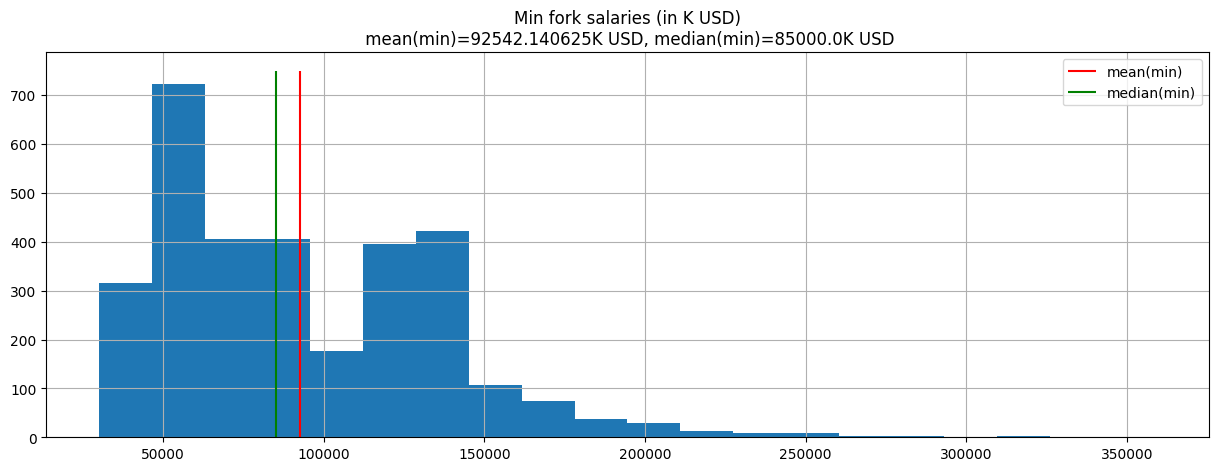

In [386]:
salary_min_usd_df['salary_min_usd'].hist(bins=20, figsize=(15,5))
mean_min = np.round( salary_min_usd_df['salary_min_usd'].mean(), 2)
median_min = salary_min_usd_df['salary_min_usd'].median()
plt.vlines(x=mean_min, ymin=0, ymax=750, color="red", label="mean(min)")
plt.vlines(x=median_min, ymin=0, ymax=750, color="green", label="median(min)")
plt.title(f"Min fork salaries (in K USD)\n mean(min)={mean_min}K USD, median(min)={median_min}K USD")
plt.legend();

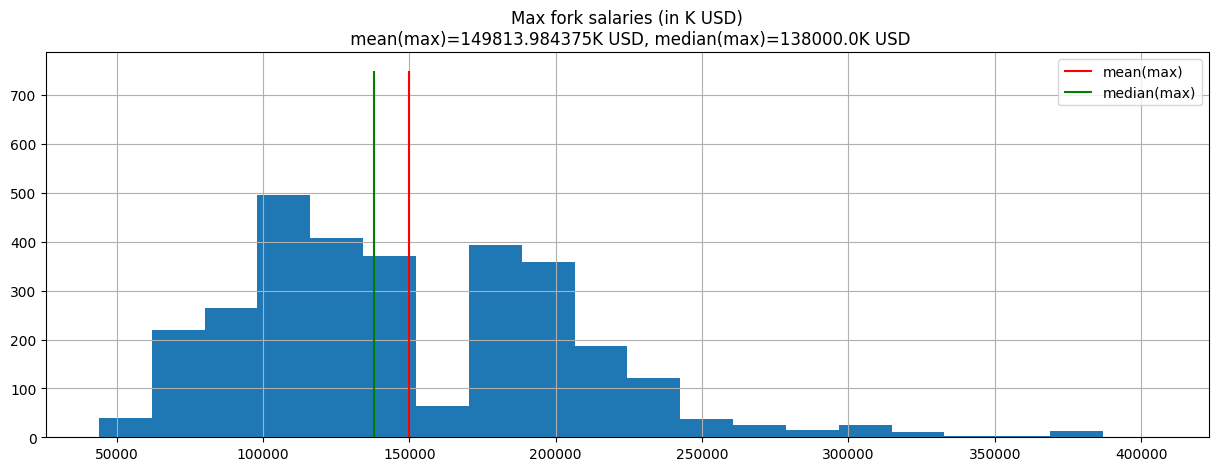

In [387]:
salary_max_usd_df=dj.select('salary_max_usd').toPandas()
salary_max_usd_df['salary_max_usd'].hist(bins=20, figsize=(15,5))
mean_min = np.round(salary_max_usd_df['salary_max_usd'].mean(), 2)
median_min = salary_max_usd_df['salary_max_usd'].median()
plt.vlines(x=mean_min, ymin=0, ymax=750, color="red", label="mean(max)")
plt.vlines(x=median_min, ymin=0, ymax=750, color="green", label="median(max)")
plt.title(f"Max fork salaries (in K USD)\n mean(max)={mean_min}K USD, median(max)={median_min}K USD")
plt.legend();

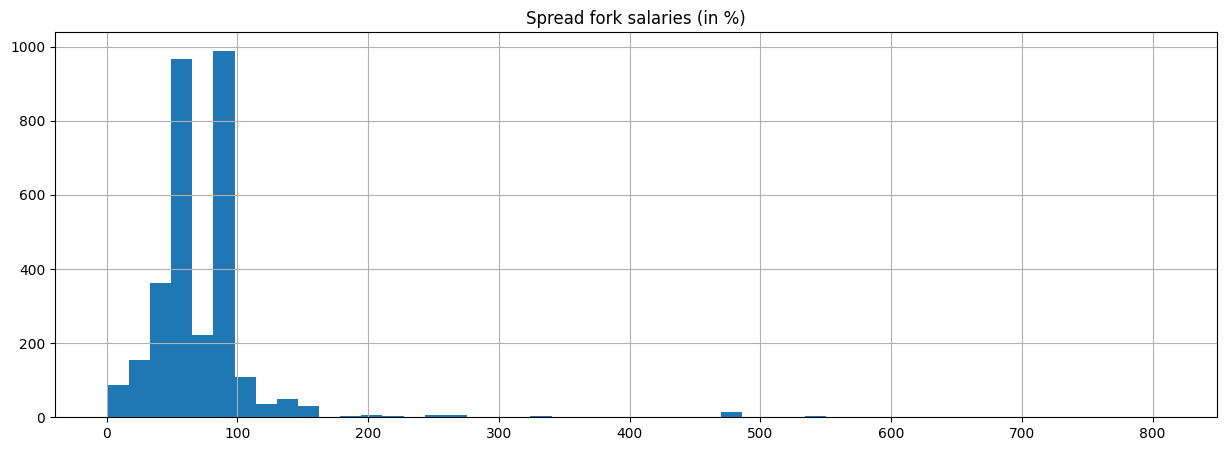

In [388]:
(

    (salary_max_usd_df['salary_max_usd'] - salary_min_usd_df['salary_min_usd'])
    / salary_min_usd_df['salary_min_usd'] * 100

).hist(bins=50, figsize=(15,5))
plt.title("Spread fork salaries (in %)");

In [389]:
dj.filter(col('salary_min_usd').isNull()).count()

122

# title

In [390]:
titles_list=[
    'data analyst',
    'data engineer',
    'data scientist',
    'ml engineer',
    'ai engineer',
    'software engineer',
    'machine learning engineer',
    'machine learning engineering',
    'machine learning scientist',
    'data analytics',
    'product manager',
    'project manager',
    'ai/ml scientist',
    'reliability engineer',
    'systems analyst',
    'business analyst',
    'research scientist',
    'director',
    'computer vision engineer',
    'prompt engineer',
    'lead data science',
    'data architect',
    'business intelligence analyst',
    'analytics engineer',
    'etl engineer',
    'software architect',
    'product owner',
    'devops engineer',
    'mlops engineer',
    'business intelligence engineer',
    'bi developer',
    'head of data',
    'data science manager'

]

In [391]:
#create column title_norm
dj=dj.withColumn('title_norm',find_matching_title_udf(col('title'),lit(titles_list)))

In [392]:
all_count=dj.count()

In [393]:
title_nulls=dj.filter(col('title_norm').isNull()).count()
print(f'Number of nulls in title_norm : {title_nulls}')
print(f'% of nulls in title_norm : {title_nulls/all_count}')

Number of nulls in title_norm : 932
% of nulls in title_norm : 0.2865928659286593


In [394]:
dj.filter(col('title_norm').isNull()).groupBy('title').count().orderBy(col('count').desc()).show(100,truncate=False)

+--------------------------------------------------------------------------------------------------------+-----+
|title                                                                                                   |count|
+--------------------------------------------------------------------------------------------------------+-----+
|senior manager, data science                                                                            |7    |
|senior consultant in data science                                                                       |4    |
|bi analyst                                                                                              |4    |
|ttgp fleet data manager/senior jico                                                                     |4    |
|implementation senior quality engineer - medical imaging/pacs                                           |4    |
|senior data science consultant                                                                 

In [395]:
dj.filter((col('seniority_level').isNull())&(col('title_norm').isNull())).count()

60

In [396]:
dj.filter((col('seniority_level').isNull())).count()

239

# location

In [397]:
location_df=dj.select('location').toPandas()

In [398]:
dj.select('location').show(100,truncate=False)

+-----------------------------------------------------------------+
|location                                                         |
+-----------------------------------------------------------------+
|Hyderabad, India                                                 |
|Johannesburg, South Africa                                       |
|Ciudad de México, Mexico                                         |
|Berlin, Germany                                                  |
|New York City                                                    |
|Austin, TX, United States                                        |
|Danvers, MA, United States                                       |
|Stuttgart, Germany                                               |
|Bengaluru, India                                                 |
|Las Cruces, New Mexico, United States                            |
|Bengaluru, India                                                 |
|Stanford, California, United States            

In [399]:
dj=dj.withColumn('joined_string',col('location'))

In [400]:

dj=dj.withColumn("joined_string", lower(dj["joined_string"]))
dj= dj.withColumn('joined_string', regexp_replace('joined_string', '[_()*/&:;.!?\\-]|\\bor\\b', ','))


In [401]:
dj.select('joined_string').show(truncate=False)

+----------------------------------------------------+
|joined_string                                       |
+----------------------------------------------------+
|hyderabad, india                                    |
|johannesburg, south africa                          |
|ciudad de méxico, mexico                            |
|berlin, germany                                     |
|new york city                                       |
|austin, tx, united states                           |
|danvers, ma, united states                          |
|stuttgart, germany                                  |
|bengaluru, india                                    |
|las cruces, new mexico, united states               |
|bengaluru, india                                    |
|stanford, california, united states                 |
|peru                                                |
|london, united kingdom                              |
|india, mumbai                                       |
|maracaibo

In [402]:
#create list of words
dj= dj.withColumn('joined_string', make_list_of_string_udf('joined_string'))

In [403]:
print('Number of nuls in joined string')
dj.filter(col('joined_string').isNull()).count()

Number of nuls in joined string


0

In [404]:
dj.select('joined_string').show(100,truncate=False)

+-------------------------------------------------------------------+
|joined_string                                                      |
+-------------------------------------------------------------------+
|[hyderabad, india]                                                 |
|[johannesburg, south africa]                                       |
|[ciudad de méxico, mexico]                                         |
|[berlin, germany]                                                  |
|[new york city]                                                    |
|[austin, tx, united states]                                        |
|[danvers, ma, united states]                                       |
|[stuttgart, germany]                                               |
|[bengaluru, india]                                                 |
|[las cruces, new mexico, united states]                            |
|[bengaluru, india]                                                 |
|[stanford, californ

In [405]:
replace_diatrics_in_list__of_strings_udf=udf(lambda list_of_strings:[replace_diacritics_with_letters(word) for word in list_of_strings],ArrayType(StringType()))

In [406]:
dj=dj.withColumn('joined_string',replace_diatrics_in_list__of_strings_udf('joined_string'))

In [407]:
dj.select('joined_string').show(100,truncate=False)

+-------------------------------------------------------------------+
|joined_string                                                      |
+-------------------------------------------------------------------+
|[hyderabad, india]                                                 |
|[johannesburg, south africa]                                       |
|[ciudad de mexico, mexico]                                         |
|[berlin, germany]                                                  |
|[new york city]                                                    |
|[austin, tx, united states]                                        |
|[danvers, ma, united states]                                       |
|[stuttgart, germany]                                               |
|[bengaluru, india]                                                 |
|[las cruces, new mexico, united states]                            |
|[bengaluru, india]                                                 |
|[stanford, californ

## country

In [408]:
COUNTRIES = ['north macedonia','nz','fra','tr','czechia','czech','it','turkiye','fr','esp','korea','Remote', 'Hybrid', 'wales','méxico','atralia','uk','holland','usa','us','england','Fiji', 'Suriname', 'Malawi', 'Vietnam', 'Serbia', 'Thailand', 'United Arab Emirates', 'Vatican City State', 'Comoros', 'Burkina Faso', 'Botswana', 'Cayman Islands', 'South Africa', 'New Caledonia', 'Singapore', 'Mongolia', 'Iraq', 'Somalia', 'Sao Tome', 'Andorra', 'Yugoslavia', 'Chad', 'Eritrea', 'Morocco', 'Central African Rep', 'Italy', 'Albania', 'Hungary', 'Ethiopia', 'Tokelau', 'Bulgaria', 'Belarus', 'Algeria', 'Barbados', 'Nigeria', 'Monaco', 'Sweden', 'Hong Kong', 'Kuwait', 'Northern Mariana Islands', 'Seychelles', 'Austria', 'Tajikistan', 'Djibouti', 'Cyprus', 'Denmark', 'Iceland', 'Guam', 'San Marino', 'Cote D`ivoire', 'Reunion', 'United Kingdom', 'Anguilla', 'Mali', 'Marshall Islands', 'Afghanistan', 'France', 'Nicaragua', 'Myanmar', 'Puerto Rico', 'Viet Nam', 'Bosnia And Herzegowina', 'Tunisia', 'St Vincent/Grenadines', 'Bangladesh', 'Uganda', 'Egypt', 'Uzbekistan', 'Laos', 'Luxembourg', 'Paraguay', 'Turkey', 'St.Pierre', 'Swaziland', 'Namibia', 'Niger', 'Tuvalu', 'Yemen', 'Romania', 'Zimbabwe', 'Haiti', 'Mozambique', 'Saint Kitts And Nevis', 'Honduras', 'Bahamas', 'Libya', 'Latvia', 'Oman', 'Antigua And Barbuda', 'Vanuatu', 'Trinidad And Tobago', 'Syrian Arab Republic', 'Antarctica', 'Micronesia', 'Germany', 'Russian Federation', 'United States', 'Greenland', 'Uruguay', 'Virgin Islands (U.S.)', 'Mauritania', 'Malta', 'Brunei Darussalam', 'Guinea', 'Liechtenstein', 'Pitcairn', 'Montserrat', 'Saudi Arabia', 'French Guiana', 'Sri Lanka', 'Mexico', 'Georgia', 'Angola', 'Philippines', 'Jamaica', 'Bolivia', 'El Salvador', 'American Samoa', 'Dominican Republic', 'Madagascar', 'Sierra Leone', 'Burundi', 'Lesotho', 'Netherlands Antilles', 'Cocos Islands', 'French S. Territories', 'Iran', 'Croatia', 'Mauritius', 'Costa Rica', 'Senegal', 'Aruba', 'Finland', 'French Polynesia', 'Equatorial Guinea', 'Tanzania', 'Cape Verde', 'Togo', 'Sudan', 'Cambodia', 'Azerbaijan', 'Congo', 'Argentina', 'Canada', 'Dominica', 'Guinea-bissau', 'Kazakhstan', 'Western Sahara', 'Mayotte', 'Indonesia', 'Kiribati', 'Zambia', 'Estonia', 'Norway', 'Peru', 'Bermuda', 'New Zealand', 'Portugal', 'Brazil', 'Bouvet Island', 'St. Helena', 'Spain', 'Belize', 'Cameroon', 'Nepal', 'Cuba', 'Netherlands', 'Virgin Islands (British)', 'Ecuador', 'Jordan', 'India', 'Belgium', 'Nauru', 'Samoa', 'Slovenia', 'Norfolk Island', 'Ukraine', 'Papua New Guinea', 'South Korea', 'Chile', 'Cook Islands', 'Korea (North)', 'Japan', 'Benin', 'Malaysia', 'Greece', 'Israel', 'Australia', 'Colombia', 'Switzerland', 'Armenia', 'Macau', 'China', 'Kyrgyzstan', 'Gibraltar', 'Martinique', 'Panama', 'Bahrain', 'Qatar', 'Turkmenistan', 'Maldives', 'Ireland', 'Taiwan', 'Kenya', 'Macedonia', 'Palau', 'Ghana', 'Falkland Islands (Malvinas)', 'East Timor', 'Liberia', 'Niue', 'Saint Lucia', 'Guadeloupe', 'Moldova', 'Slovakia', 'Lebanon', 'Poland', 'Gambia', 'Zaire', 'Faroe Islands', 'Bhutan', 'Venezuela', 'Guyana', 'Gabon', 'Rwanda', 'Czech Republic', 'Guatemala', 'Lithuania', 'Solomon Islands', 'Tonga', 'Pakistan', 'Grenada', 'Christmas Island']
countries=[country.lower() for country in COUNTRIES]
countries=[replace_diacritics_with_letters(country) for country in COUNTRIES]

replace_countries_dict={
    'wales':'united kingdom',
    'uk':'united kingodm',
    'england':'united kingdom',
    'us':'united states',
    'usa':'united states',
    'méxico':'mexico',
    'atralia':'australia',
    'holland':'netherlands',
    'turkiye':'turkey',
    'fr':'france',
    'fra':'france',
    'esp':'spain',
    'czechia':'czech republic',
    'czech':'czech republic',
    'it':'italy',
    'nl':'netherlands',
    'tr':'turkey',
    'nz':'new zealand',
    'north macedonia':'macedonia'

}


In [409]:
print(f'Number of countries in countries list {len(countries)}')

Number of countries in countries list 254


In [410]:
#check if macedonia on countries list
print({'macedonia'}&set(countries))

{'macedonia'}


In [411]:
#find all countries from countries list in each row of joined_string and move to new column country
dj=dj.withColumn('country',make_column_udf('joined_string',lit(countries)))

In [412]:
#create number_of_countries column  wirh info on countries in each country column  row
dj=dj.withColumn('number_of_countries',make_length_column_udf('country'))

In [413]:
#create new joinedString_space column by spliting location by space char
dj=dj.withColumn("joined_string_space", lower(dj["location"]))
dj= dj.withColumn('joined_string_space', regexp_replace('joined_string_space', '[_()*/&:;.!?\\-]|\\bor\\b', ','))

dj=dj.withColumn('joined_string_space',make_list_of_string_udf('joined_string_space',lit(' ')))



In [414]:
# add contries found in joined_string_space if numbe_of countries=0
dj = dj.withColumn('country', when(col('number_of_countries') == 0, make_column_udf('joined_string_space', lit(countries))).otherwise(col('country')))

In [415]:
# replace country name according to replace_countries_dict dictionary

dj=dj.withColumn('country',replace_word_with_dict_udf('country',lit(list(replace_countries_dict.keys())),lit(list(replace_countries_dict.values()))))

In [416]:
#make country unique in countries row
dj=dj.withColumn('country',make_distinct_column_udf(col('country')))


In [417]:
dj=dj.withColumn('number_of_countries',make_length_column_udf('country'))

In [418]:
print(f'Number of rows with no country name: {dj.filter(col("number_of_countries")==0).count()}')

Number of rows with no country name: 589


In [419]:
print(f'Number of rows in country with more then one country {dj.filter(col("number_of_countries")>1).count()}')

Number of rows in country with more then one country 246


In [420]:
dj=dj.withColumn('number_of_countries',make_length_column_udf('country'))

In [421]:
print(f'Number of rows with no country name: {dj.filter(col("number_of_countries")==0).count()}')

Number of rows with no country name: 589


In [422]:
print(f'Number of rows before exploding country column {dj.count()}')

Number of rows before exploding country column 3252


In [423]:
# exploding dj on country column to make country single
dj=dj.withColumn("country", explode_outer("country"))

In [424]:
print(f'Number of rows after exploding country column {dj.count()}')

Number of rows after exploding country column 3504


In [425]:
print(dj.select('country').dtypes)

[('country', 'string')]


In [426]:
dj=dj.withColumn('number_of_countries',when(col('country').isNotNull(),1).otherwise(0))

In [427]:
dj.select('number_of_countries').distinct().show()

+-------------------+
|number_of_countries|
+-------------------+
|                  1|
|                  0|
+-------------------+



## cities

In [428]:
cities_raw.show()

+------------+------------+--------+--------+-------------+----+----+--------------------+-------+----------+----------+
|        city|  city_ascii|     lat|     lng|      country|iso2|iso3|          admin_name|capital|population|        id|
+------------+------------+--------+--------+-------------+----+----+--------------------+-------+----------+----------+
|       Tokyo|       Tokyo| 35.6897|139.6922|        Japan|  JP| JPN|               Tōkyō|primary|  37732000|1392685764|
|     Jakarta|     Jakarta| -6.1750|106.8275|    Indonesia|  ID| IDN|             Jakarta|primary|  33756000|1360771077|
|       Delhi|       Delhi| 28.6100| 77.2300|        India|  IN| IND|               Delhi|  admin|  32226000|1356872604|
|   Guangzhou|   Guangzhou| 23.1300|113.2600|        China|  CN| CHN|           Guangdong|  admin|  26940000|1156237133|
|      Mumbai|      Mumbai| 19.0761| 72.8775|        India|  IN| IND|         Mahārāshtra|  admin|  24973000|1356226629|
|      Manila|      Manila| 14.5

In [429]:
#create cities dataframe
cities=cities_raw.select('city_ascii','country').na.drop()
cities=cities.withColumn('city_ascii',replace_diacritics_with_letters_udf(col('city_ascii')))
cities=cities.withColumn('country',replace_diacritics_with_letters_udf(col('country')))

In [430]:
# adding new cities to cities dataframe
update_countries_dict = {
    'taguig': 'philippines',
    'mysore': 'india',
    'bengaluru': 'india'
}

update_city_with_countries_df = spark.createDataFrame([Row(city_ascii=k, country=v) for k, v in update_countries_dict.items()])

# Dołączanie ramki danych update_df do ramki danych city_with_country
cities = cities.union(update_city_with_countries_df)

In [431]:
cities.show()

+------------+-------------+
|  city_ascii|      country|
+------------+-------------+
|       tokyo|        japan|
|     jakarta|    indonesia|
|       delhi|        india|
|   guangzhou|        china|
|      mumbai|        india|
|      manila|  philippines|
|    shanghai|        china|
|   sao paulo|       brazil|
|       seoul| korea, south|
| mexico city|       mexico|
|       cairo|        egypt|
|    new york|united states|
|       dhaka|   bangladesh|
|     beijing|        china|
|     kolkata|        india|
|     bangkok|     thailand|
|    shenzhen|        china|
|      moscow|       russia|
|buenos aires|    argentina|
|       lagos|      nigeria|
+------------+-------------+
only showing top 20 rows



In [432]:
# creating set of cities

selected_cities = cities.select("city_ascii")
cities_list=[row["city_ascii"] for row in selected_cities.select("city_ascii").collect()]
cities_list=[replace_diacritics_with_letters(city) for city in cities_list if city is not None]
cities_set=set(cities_list)

In [433]:
# selected_cities = cities.orderBy("population").select("name")
# cities_list=[row['name'] for row in selected_cities.select('name').collect()]
# cities_list=[replace_diacritics_with_letters(city) for city in cities_list if city is not None]


In [434]:
print(f'Number of cities on cities_list: {len(cities_list)}')

Number of cities on cities_list: 47870


In [435]:
extra_cities_manual_input={'11700 cuidad de mexico', 'annapolis junction', 'antioquia', 'baltimore area', 'beaubourg', 'bengaluru north', 'beograd', 'billancourt', 'boulogne', 'br sao paulo', 'brentford', 'brussels hoofdstedelijk gewest', 'ca | montreal', 'cardiff', 'cau giay', 'comunidad de madrid', 'county dublin', 'croissy', 'da nang city', 'dubai emirate', 'dublin 1', 'frankfurt am main', 'geneve', 'greater boston', 'greater skopje', 'gurugram', 'gush dan', 'herblain', 'hkg', 'ho chi minh', 'hong kong sar', 'islamabad capital territory', 'jakarta barat', "julian's", 'kobenhavn', 'koln', 'kyiv city', 'le plessis', 'leuven', 'levallois', 'littlemore', 'london office', 'lviv oblast', 'makati', 'metro manila', 'metropolitan city of milan', 'milano', 'moulineaux', 'munchen', 'mysore', 'napoca', 'navi mumbai', 'new cairo city', 'noord', 'north sydney', 'palma de mallorca', 'pasay', 'pasig', 'perret', 'porto district', 'prague 4', 'pt lisboa', 'pt porto', 'quan 1', 'quan 4', 'quebec | remote', 'san francisco hq', 'santiago de queretaro', 'shoreditch', 'state of sao paulo', 'taguig', 'tan binh', 'tel aviv district', 'torino', 'valencian community', 'valle del cauca', 'villeneuve', 'vilnius city municipality','san francisco bay area', 'barcelona area'}

In [436]:
replace_cities_dict_manual_input={'state of sao paulo': 'sao paulo',
 'prague 4': 'prague',
 'tel aviv district': 'tel aviv',
 'kyiv city': 'kyiv',
 'levallois': 'levallois-perret',
 'perret': 'levallois-perret',
 'metropolitan city of milan': 'milan',
 'county dublin': 'dublin',
 'beograd': 'belgrade',
 'milano': 'milan',
 "julian's": "st.julian's",
 'herblain': 'saint-herblain',
 'dublin 1': 'dublin',
 'munchen':'munich',
 'koln': 'cologne',
 'porto district': 'porto',
 'metro manila': 'manila',
 'frankfurt am main': 'frankfurt',
 'hong kong sar': 'hong kong',
 'lviv oblast': 'lviv',
 'islamabad capital territory': 'islamabad',
 'navi mumbai': 'mumbai',
 'comunidad de madrid': 'madrid',
 'shoreditch': 'london',
 'bengaluru north': 'bengaluru',
 'boulogne': 'boulogne-billancourt',
 'billancourt': 'boulogne-billancourt',
 'kobenhavn': 'copenhagen',
 'vilnius city municipality': 'vilnius',
 'cau giay': 'hanoi',
 'san francisco hq': 'san francisco',
 'dubai emirate': 'dubai',
 'pt porto': 'porto',
 'torino': 'turin',
 'brentford': 'london',
 'da nang city': 'da nang',
 'annapolis junction': 'annapolis',
 'jakarta barat': 'jakarta',
 'ca | montreal': 'montreal',
 'quebec | remote': 'quebec',
 'brussels hoofdstedelijk gewest': 'brussels',
 'quan 1': 'quan',
 'valencian community': 'valencia',
 'hkg': 'hong kong',
 'new cairo city': 'cairo',
 'littlemore': 'oxford',
 'greater boston': 'boston',
 'baltimore area': 'baltimore',
 'greater skopje': 'skopje',
 'palma de mallorca': 'palma de malorca',
 '11700 cuidad de mexico': 'mexico city',
 'quan 4': 'quan',
 'pt lisboa': 'lisbon',
 'le plessis': 'le plessis-robinson',
 'br sao paulo': 'sao paulo',
 'north sydney': 'sydney',
 'antioquia': 'antiochia',
 'london office': 'london',
 'croissy': 'croissy-beaubourg',
 'geneve':'geneva',
 'beaubourg': 'croissy-beaubourg',
 'quebec':'quebec city',
 'san francisco bay area':'san francisco',
 'barcelona area':'barcelona'}

In [437]:
extra_cities={'new york city','ny','attica','tel aviv','brooklyn','lisboa','bangkok metropolis','yafo','foster city',
              'ciudad de mexico','renningen','warszawa','courbevoie','athina','chantilly','cracow','batu kawan',
              'ca * new york city * united states','herndon','menlo park','north reading','ispra','taipei city',
              'community of madrid','bengaluru','quebec'}

replace_cities_dict={
    'new york city':'new york',
    'ca * new york city * united states':'new york',
    'ny':'new york',
    'tel aviv':'tel aviv-yafo',
    'brooklyn':'new york',
    'lisboa':'lisbon',
    'bangkok metropolis':'bangkok',
    'yafo':'tel aviv-yafo',
    'ciudad de mexico':'mexico city',
    'warszawa':'warsaw',
    'athina':'athens',
    'cracow':'krakow',
    'taipei city':'taipei',
    'community of madrid':'madrid',
    'napoca':'cluj-napoca'


}

In [438]:
# remove from cities set names of states
remove_from_cities={'wa','pa','usa'}

In [439]:
# full set of cities cretaed from intial world cities dataset and manual update
cities_set_full=cities_set.union(extra_cities).union(extra_cities_manual_input).difference(remove_from_cities)


In [440]:
print('cities set',len(cities_set))
print('extra cities',len(extra_cities))
print('extra cities manual input',len(extra_cities_manual_input))
print('cities_set_full',len(cities_set_full))

cities set 44157
extra cities 26
extra cities manual input 80
cities_set_full 44250


In [441]:
# create set of cities which are in column joined string and cities_set_full. cities_in joined_string
# wiil shorten creation of cities column in the next step
cities_in_joined_string=cities_set_full&set(get_words_from_column(dj,'joined_string'))

In [442]:
# creating new column cities
dj=dj.withColumn('cities',make_column_udf('joined_string',lit(list(cities_in_joined_string))))

In [443]:
dj.groupBy('cities').count().orderBy(col("count").desc()).show(500,truncate=False)

+---------------------------------------------------------+-----+
|cities                                                   |count|
+---------------------------------------------------------+-----+
|[]                                                       |290  |
|[paris]                                                  |109  |
|[bengaluru]                                              |107  |
|[london]                                                 |100  |
|[new york city]                                          |93   |
|[san francisco]                                          |62   |
|[hyderabad]                                              |58   |
|[singapore]                                              |53   |
|[berlin]                                                 |46   |
|[chicago]                                                |43   |
|[toronto]                                                |42   |
|[warsaw]                                                 |40   |
|[boston] 

In [444]:
dj=dj.withColumn('number_of_cities',make_length_column_udf('cities'))

In [445]:
print(f'Number of cities with null : {dj.filter(col("number_of_cities")==0).count()}')

Number of cities with null : 290


In [446]:
# show joined string when no city name created
dj.filter(col('number_of_cities')==0).select('joined_string').show(300,truncate=False)

+------------------------------------------------------+
|joined_string                                         |
+------------------------------------------------------+
|[costa rica]                                          |
|[germany]                                             |
|[remote, romania]                                     |
|[remote, romania]                                     |
|[remote, md, united states]                           |
|[remote, md, united states]                           |
|[rosebank, gauteng, south africa]                     |
|[remote, india]                                       |
|[remote, india]                                       |
|[brazil]                                              |
|[united states, remote]                               |
|[united states, remote]                               |
|[vietnam, remote]                                     |
|[vietnam, remote]                                     |
|[steenderen, netherlands]     

In [447]:
# creating replace_cities_dict_full dictionary to replace cities name with proper ones
replace_cities_dict_full={**replace_cities_dict,**replace_cities_dict_manual_input}

In [448]:
print(f'replace_cities_dict_full : {len(replace_cities_dict_full)}')
print(f'replace_cities_dict : {len(replace_cities_dict)}')
print(f'replace_cities_dict_manual_input : {len(replace_cities_dict_manual_input)}')

replace_cities_dict_full : 79
replace_cities_dict : 15
replace_cities_dict_manual_input : 64


In [449]:
print(f'NUmber of words in cities before consolidation: {len(get_number_words_on_list(get_words_from_column(dj,"cities")))}')

NUmber of words in cities before consolidation: 568


In [450]:
dj=dj.withColumn('cities',replace_word_with_dict_udf('cities',lit(list(replace_cities_dict_full.keys())),lit(list(replace_cities_dict_full.values()))))

In [451]:
print(f'NUmber of words in cities after consolidation: {len(get_number_words_on_list(get_words_from_column(dj,"cities")))}')

NUmber of words in cities after consolidation: 510


In [452]:
# make values in cities column distinct
dj=dj.withColumn('cities',make_distinct_column_udf(col('cities')))



In [453]:
# check for duplicates in 'cities'
dj.filter(size(col('cities')) > size(array_distinct(col('cities')))).select('cities').show(100,truncate=False)

+------+
|cities|
+------+
+------+



In [454]:
#exploding dj to make single value in city column
dj=dj.withColumn("city", explode_outer("cities"))

## update country with cities info

In [455]:
print(f'Number of rows with no country {dj.filter(col("number_of_countries")==0).count()}')

Number of rows with no country 704


In [456]:
print(f'Number of rows with no country and with not city {dj.filter((col("number_of_countries")==0) & (col("number_of_cities")==0)).count()}')

Number of rows with no country and with not city 0


In [457]:
dj = dj.join(cities.withColumnRenamed("country", "country_from_city_with_country"),
                         dj["city"] == cities["city_ascii"], "left")



In [458]:
#update value in country with when country is null
dj = dj.withColumn("country", when(col("country").isNull(), col("country_from_city_with_country")).otherwise(col("country")))


In [459]:
print(f'Number of rows with no country {dj.filter(col("country").isNull()).count()}')


Number of rows with no country 0


# company_name

In [460]:
print(f'Number of distinct company name {dj.select("company_name").distinct().count()}')

Number of distinct company name 1047


In [461]:
dj.filter(col("company_name").contains(',')).select('company_name').distinct().show(truncate=False)

+--------------------------+
|company_name              |
+--------------------------+
|Vuori, Inc                |
|Riot Games, Inc.          |
|Faire Wholesale, Inc.     |
|AppZen, Inc.              |
|HeartFlow, Inc.           |
|Project Canary, PBC       |
|ProSidian Consulting, LLC |
|UWorld, LLC               |
|DataCamp, Inc.            |
|Procentrix, Inc.          |
|OCT Consulting, LLC       |
|PaneraTech, Inc.          |
|Form Energy, Inc          |
|Genies, Inc.              |
|Aeva, Inc.                |
|Truebill, Inc.            |
|Plentific, Ltd.           |
|TechFlow, Inc             |
|EMW, Inc.                 |
|Vision Point Systems, Inc.|
+--------------------------+
only showing top 20 rows



In [462]:
dj.select('company_name').distinct().show(truncate=False)

+--------------------------------------+
|company_name                          |
+--------------------------------------+
|McGrathNicol                          |
|SupportNinja                          |
|Eurowag                               |
|IBI Group                             |
|Wyetech                               |
|Shape Therapeutics                    |
|LeddarTech                            |
|Qoria                                 |
|Version 1                             |
|ClickUp                               |
|INX International Ink Co.             |
|Nayya                                 |
|Domo                                  |
|iKnowHow S.A.                         |
|Azumo                                 |
|Vonage                                |
|Deutsche Telekom IT Solutions Slovakia|
|iTechScope                            |
|Thumbtack                             |
|Adstart Media                         |
+--------------------------------------+
only showing top

In [463]:
dj.select('company_description').show(50,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------+
|company_description                                                                                                                                     |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
|2K publishes titles in today's most popular gaming genres, including shooters, action, role-playing, strategy, sports, casual, and family entertainment.|
|2K publishes titles in today's most popular gaming genres, including shooters, action, role-playing, strategy, sports, casual, and family entertainment.|
|2K publishes titles in today's most popular gaming genres, including shooters, action, role-playing, strategy, sports, casual, and family entertainment.|
|2K publishes titles in today's most popular gaming genres, including 

# Experiments

In [252]:
mlflow.pyspark.ml.autolog()

In [248]:
from itertools import combinations

# Lista kolumn cech
features_cols = ['seniority_level','title_norm', 'city']#company_name']

# Generowanie wszystkich kombinacji długości 0 do len(features_cols)
all_combinations = []
for r in range(1,len(features_cols) + 1):
    all_combinations.extend(combinations(features_cols, r))

# Wyświetlenie wygenerowanych kombinacji
for combination in all_combinations:
    print(combination)

print(len(all_combinations))

('seniority_level',)
('title_norm',)
('city',)
('seniority_level', 'title_norm')
('seniority_level', 'city')
('title_norm', 'city')
('seniority_level', 'title_norm', 'city')
7


In [ ]:
features_cols=['seniority_level','title_norm', 'city','company_name']
label_col='salary_min_usd'

djp=create_featured_df(dj,features_cols,label_col)
djp=djp.filter(col(label_col).isNotNull())

#djp_train,djp_test=djp.randomSplit([0.8,0.2],seed=23)
djp=djp.filter(~((col('seniority_level').isNull())&(col('title_norm').isNull())))

models = [LinearRegression()]#, DecisionTreeRegressor(), GBTRegressor(), RandomForestRegressor()]

for model in models:
  metrics=run_model_cv(model,djp,features_cols,pred_col='prediction',
                       comments='seniority_level Null and title_norm NUll removed , GPU')

# Conclusions

In [249]:

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

num_runs = len(mlflow.search_runs(experiment_ids=[experiment_id]))
print("Number of runs :", num_runs)

Number of runs : 146


In [250]:
all_metrics = mlflow.search_runs(experiment_ids=[experiment_id], filter_string="")


metric_names = all_metrics.columns[all_metrics.columns.str.startswith('metrics.')].unique().tolist()


print("Logged metrics:")
print(metric_names)

Logged metrics:
['metrics.mae_test', 'metrics.std_mae', 'metrics.avg_mae', 'metrics.rmse_test', 'metrics.mse_test', 'metrics.r2_test']


In [251]:

top_runs = mlflow.search_runs(experiment_ids=[experiment_id], order_by=["metrics.mae_test"], max_results=10)

print("Number of runs:", num_runs)

top_runs[['tags.mlflow.runName','params.features_cols', 'metrics.mae_test','tags.comments']]

Number of runs: 146


,tags.mlflow.runName,params.features_cols,metrics.mae_test,tags.comments
0,LinearRegression,"['seniority_level', 'working_hour', 'salary_mi...",700.279630,data leak!
1,LinearRegression,"['seniority_level', 'title_norm', 'city', 'com...",15767.159204,"seniority_level and title_norm no nulls, GPU"
2,LinearRegression,"['seniority_level', 'title_norm', 'city', 'wor...",15767.593919,"seniority_level and title_norm no nulls, GPU"
3,LinearRegression,"['seniority_level', 'title_norm', 'city', 'wor...",15854.625938,"title_norm no nulls, GPU"
4,LinearRegression,"['seniority_level', 'title_norm', 'city', 'wor...",15854.625938,"title_norm no nulls, GPU"
5,LinearRegression,"['seniority_level', 'title_norm', 'city', 'cou...",16096.099899,"seniority_level and title_norm no nulls, GPU"
6,LinearRegression,"['seniority_level', 'title_norm', 'city', 'wor...",17402.911589,"title_norm with nulls, GPU"
7,LinearRegression,"['seniority_level', 'title_norm', 'city', 'com...",17422.675677,"all nulls included, GPU"
8,LinearRegression,"['seniority_level', 'title_norm', 'city', 'com...",17708.424492,seniority_level Null and title_norm NUll remov...
9,GBTRegressor,"['seniority_level', 'title_norm', 'city', 'wor...",18581.190086,"title_norm no nulls, GPU"


Models tested : LinearRegression(), DecisionTreeRegressor(), GBTRegressor(), RandomForestRegressor()

Feature selection : all combinations of features tested.

Best model with all nulls included :
*   Model : linear regression
*   Features : seniority_level, title_norm, city, company_name
*   MAE: 17422

Features selection:
* 'country'  deteriorates the results.
* 'wokring hour' not much varability








# Next steps:

* work on nulls in 'seniority_level' and 'title_norm' (important gain as models metrics show 15k for no nulls data versus 17k wiht all nulls included)
* move further with features engineering: 1/ new column like " domain" 2/ get info and create features from block column
* models parameters tuning
* try ensemble lerning with different models
